<a href="https://colab.research.google.com/github/rahiakela/feature-extraction-and-image-processing-for-computer-vision/blob/master/3-image_processing/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image processing

First, we shall describe the brightness variation in an image using its histogram. We shall then look at operations which manipulate the image so as to change the histogram, and at processes that shift and scale the result (making the image brighter or dimmer, in different ways). We shall also consider thresholding techniques that turn an image from grey level into binary. These are called single point operations. After, we shall move to group operations where the group is those points found inside a template. Some of the most common operations on the groups of points are statistical, providing images where each point is the result of, say, averaging the neighbourhood of each point in the original image.

## Setup

In [26]:
#Set module functions
from ImageUtilities import imageReadL, showImageL, createVectorI, createImageL
from PlotUtilities import plotHistogram
from ImageOperatorsUtilities import computeHistogram
from ImagePropertiesUtilities import imageMaxMin

# Iteration
from timeit import itertools
from math import log, exp

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Image Histogram

The intensity histogram shows how individual brightness levels are occupied in an image; the image contrast is measured by the range of brightness levels. The histogram plots the number of pixels with a particular brightness level against the brightness level.

For 8-bit pixels, the brightness ranges from zero (black) to 255 (white).

Note that the image contains many light grey pixels that produce the wide lower peak in the histogram. If the image was darker, overall, the histogram would be concentrated towards black. If the image was brighter, but with lower contrast, then the histogram would be thinner and concentrated near the whiter brightness levels.




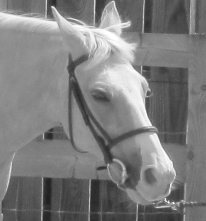

In [2]:
imageName = "Horse.png"
scale = 1.0
translation = 0.0

# Read image into array
inputImage, width, height  = imageReadL(imageName)
outputImage = Image.fromarray(inputImage, 'L')
outputImage

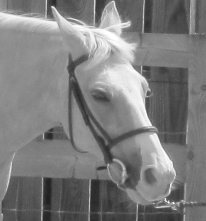

In [3]:
# Transform the image
for x, y in itertools.product(range(0, width), range(0, height)):
  b = int(scale * float(inputImage[y, x]) + translation)
  inputImage[y, x] = max(0, min(b, 255))
Image.fromarray(inputImage, 'L')

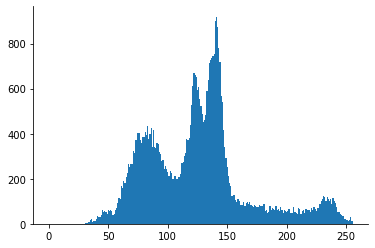

In [4]:
# Vector of integers values to store the number of times a pixel value is repeated
outputHistogram = createVectorI(256)

# Get the number of times a pixel value is found in the image
for x, y in itertools.product(range(0, width), range(0, height)):
  pixelValue = inputImage[y, x]
  outputHistogram[pixelValue] += 1

# Plot histogram
plotHistogram(outputHistogram)

This histogramshows us that we have not used all available grey levels. Accordingly, we can stretch the image to use them all, and the image would become clearer. This is essentially cosmetic attention to make the image’s appearance better.

## Point operators

### Basic point operations

The most basic operations in image processing are point operations where each pixel value is replaced with a new value obtained from the old one. If we want to increase the brightness to stretch the contrast we can simply multiply all pixel values by a scalar, say by two to double the range. 

Conversely, to reduce the contrast (though this is not usual), we can divide all point values by a scalar. If the overall brightness is controlled by a level, $l$ (e.g. the brightness of global light) and the range is controlled by a gain, $k$, the brightness of the points in a new picture, $N$, can be related to the brightness in old picture, $O$, by

$$N_{x,y} = k \times O_{x, y}+ l    \space \space \space \forall x, y \in 1,N$$

This is a point operator that replaces the brightness at points in the picture according to a linear brightness relation. The level controls overall brightness and is the minimum value of the output picture. The gain controls the contrast, or range, and if the gain is greater than unity, the output range will be increased.

Finally, rather than simple multiplication, we can use arithmetic functions such as the logarithm to reduce the range or the exponent to increase it.

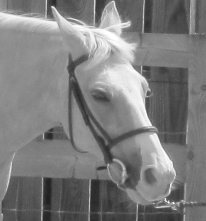

In [7]:
imageName = "Horse.png"
intevalSize = 64

# Read image into array
inputImage, width, height  = imageReadL(imageName)

# Show input image
outputImage = Image.fromarray(inputImage, 'L')
outputImage

In [14]:
# Create 3 images to store the result of 3 operators
outputSawtoothImage = createImageL(width, height)
outputLogarithmicImage = createImageL(width, height)
outputExponentialImage = createImageL(width, height)

# Set the pixels in the output image
for x, y in itertools.product(range(0, width), range(0, height)):
  inputValue = int(inputImage[y, x])

  # Set the pixels in the sawtooth image
  pixelInInterval = inputValue % intevalSize
  gain = float(pixelInInterval) / float(intevalSize)
  outputSawtoothImage[y, x] = inputValue * gain

  # Set the pixels in the Logarithmic
  outputLogarithmicImage[y, x] = 20 * log(inputValue * 100.0)
  # Set the pixels in the Exponential image
  outputExponentialImage[y, x] = 20 * exp(inputValue / 100.0)

# Compute histograms
histogramSawtoothImage = computeHistogram(outputSawtoothImage)
histogramLogarithmicImage = computeHistogram(outputLogarithmicImage)
histogramExponentialImage = computeHistogram(outputExponentialImage)

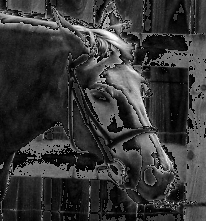

In [17]:
# Show output images
Image.fromarray(outputSawtoothImage, 'L')

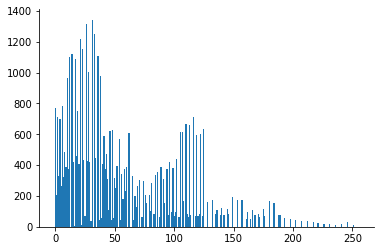

In [23]:
# Plot histograms
plotHistogram(histogramSawtoothImage)

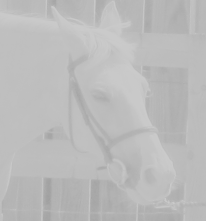

In [18]:
Image.fromarray(outputLogarithmicImage, 'L')

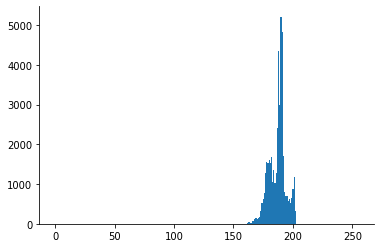

In [24]:
plotHistogram(histogramLogarithmicImage)

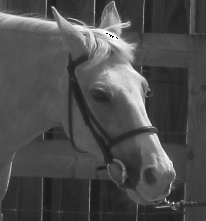

In [19]:
Image.fromarray(outputExponentialImage, 'L')

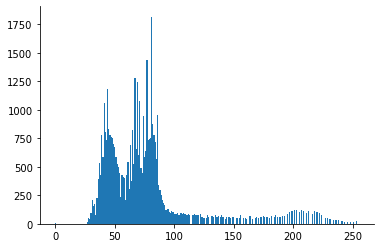

In [25]:
plotHistogram(histogramExponentialImage)

Naturally, application of the logarithmic point operator will change any multiplicative changes in brightness to become additive. As such, the logarithmic operator can find application in reducing the effects of multiplicative intensity change. The logarithm operator is often used to
compress Fourier transforms for display purposes. This is because the d.c. component can be very large, or the contrast too large, to allow the other points to be seen.

### Histogram normalisation

Popular techniques to stretch the range of intensities include histogram (intensity) normalisation. Here, the original histogram is stretched, and shifted, to cover all the 256 available levels.

If the original histogram of an old picture $O$ starts at $Omin$ and extends up to $Omax$ brightness levels, then we can scale up the image so that the pixels in the new picture $N$ lie between a minimum output level $Nmin$ and a maximum level $Nmax$, simply by scaling up the input intensity levels according to:

$$N_{x, y} = \frac{Nmax - Nmin}{Omax - Omin} \times (O{x,y} - Omin) + Nmin \space\space\space \forall x,y \in 1, N$$



In [27]:
# Create image to store the normalization
outputNormalizedImage = createImageL(width, height)

# Maximum and range
max_val, min_val = imageMaxMin(inputImage)
brightRange = float(max_val - min_val)

# Set the pixels in the output image
for x, y in itertools.product(range(0, width), range(0, height)):
  # Normalize the pixel value according to the range
  outputNormalizedImage[y, x] = round((inputImage[y, x] - min_val) * 255.0 / brightRange)

# Compute histogram
histogramNormalizedImage = computeHistogram(outputNormalizedImage)

We uses an output ranging from Nmin ¼ 0 to Nmax ¼ 255 that is the maximum range for images that use a byte per pixel. This is scaled by the input range that is determined from the maximum and minimum values are returned by the imageMaxMin function.

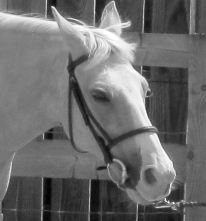

In [30]:
# Show output image and plot histogram
Image.fromarray(outputNormalizedImage, 'L')

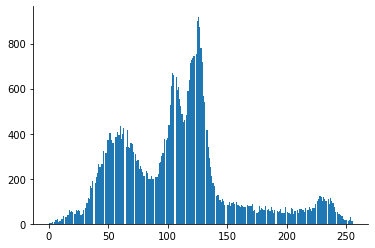

In [31]:
plotHistogram(histogramNormalizedImage)

An intensity-normalised version of the image is shown above which now has better contrast and appears better to human vision. Its histogram, shows that the intensity now ranges across all available levels (there is actually one black pixel!).

### Histogram equalisation